In [13]:
import matplotlib.pyplot as plt
import pandas as pd
# import numpy as np

df_punt_1 = pd.read_csv("metingen/kleine_kamer_punt_1_180Hz.csv", delimiter=",")
df_punt_2 = pd.read_csv("metingen/kleine_kamer_punt_2_180Hz.csv", delimiter=",")
df_punt_3 = pd.read_csv("metingen/kleine_kamer_punt_3_180Hz.csv", delimiter=",")
df_punt_4 = pd.read_csv("metingen/kleine_kamer_punt_4_180Hz.csv", delimiter=",")

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
def generate(dfs):
    # Create a grid of subplots with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    fig.tight_layout(pad=2)

    for i in range(len(dfs)):
        df = dfs[i]
        df_matrix = df.pivot("x (m)", "y (m)", "nagalmtijd (s)")

        # Plot the heatmap with origin in the left corner
        sns.heatmap(df_matrix, cmap="YlGnBu", annot=True, fmt=".1f", cbar=False, ax=axs[i])
        axs[i].set_title("Heatmap " + str(i + 1))
        axs[i].set_xlabel("X-axis (m)")
        axs[i].set_ylabel("Y-axis (m)")

    # Add a colorbar for all heatmaps
    cbar = fig.colorbar(axs[0].collections[0], ax=axs, location="right", shrink=1)
    cbar.ax.set_ylabel("Nagalmtijd (s)", rotation=270, labelpad=20)

    plt.show()

generate([df_a, df_b, df_c])

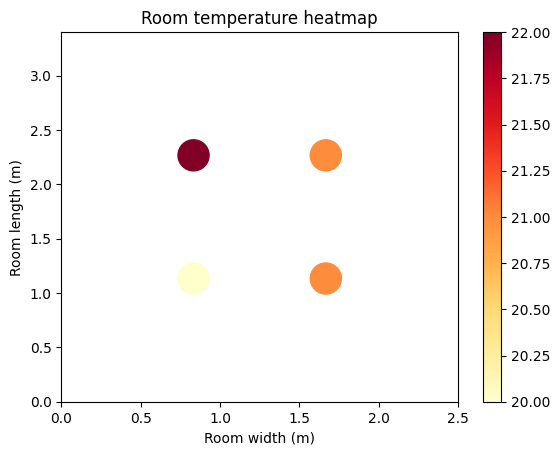

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Define the dimensions of the room
room_length = 3.4 # in meters
room_width = 2.5 # in meters

# Define the coordinates of the 4 points in the room
point_1 = (room_width/3, room_length/3)
point_2 = (2*room_width/3, room_length/3)
point_3 = (room_width/3, 2*room_length/3)
point_4 = (2*room_width/3, 2*room_length/3)

# Define the X-axis values for the heatmap
x_values = [point_1[0], point_2[0], point_3[0], point_4[0]]

# Define the values for the heatmap
# In this example, the values represent temperature at each point in the room
heatmap_values = np.array([20, 21, 22, 21])

# Create the heatmap using Matplotlib's scatter() function
fig, ax = plt.subplots()
im = ax.scatter(x_values,
                [point_1[1], point_2[1], point_3[1], point_4[1]],
                c=heatmap_values, cmap='YlOrRd', s=500)

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the X and Y axis labels for the heatmap
ax.set_xlabel('Room width (m)')
ax.set_ylabel('Room length (m)')

# Room limits
ax.set_xlim(0, room_width)
ax.set_ylim(0, room_length)

# Set the title of the heatmap
ax.set_title("Room temperature heatmap")

# Show the plot
plt.show()
